# 一个好听的名字

大可不必

## 导入包

In [7]:
from operator import length_hint
import pandas as pd
import numpy as np
import radiomics
from radiomics import featureextractor    # 有个yaml文件可以进行配置
from sklearn.utils import shuffle
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import train_test_split, cross_val_score,KFold,RepeatedKFold,GridSearchCV
from scipy.stats import pearsonr, ttest_ind, levene
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import matplotlib

## 特征提取

In [8]:
%perl -0
import radiomics
from radiomics import featureextractor
import os
import pandas as pd


dataDir = "../4.NII"
imageName = "data_MR.nii"
maskName = 'Mask2.nii.gz'
yamlName = 'Params.yaml'

imagePath = os.path.join(dataDir, imageName)
maskPath = os.path.join(dataDir , maskName)
para_path = os.path.join(dataDir , yamlName)
extractor = featureextractor.RadiomicsFeatureExtractor(para_path)
featureVector = extractor.execute(imagePath, maskPath)

df_add = pd.DataFrame.from_dict(featureVector.values()).T
df_add.columns = featureVector.keys()
df_add.to_csv(os.path.join(dataDir, "results_extract.csv"))

UsageError: Line magic function `%perl` not found (But cell magic `%%perl` exists, did you mean that instead?).


## 数据读取与处理

从路径中读取数据。

数据`data_a.csv`包含xxx……

In [9]:
xlsx1_filepath = "./data/data_a.csv"
xlsx2_filepath = "./data/data_b.csv"
data1 = pd.read_csv(xlsx1_filepath)
data2 = pd.read_csv(xlsx2_filepath)

把读取的数据整理成合适的结构

In [10]:
rows_1,__ = data1.shape
rows_2,__ = data2.shape
data1.insert(0,'label',[0]*rows_1)
data2.insert(0,'label',[1]*rows_2)
data = pd.concat([data1,data2])
data = shuffle(data)
data = data.fillna(0)
X = data[data.columns[24:]]
y = data['label']
colNames = X.columns
X = X.astype(np.float64)
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X)
X.columns = colNames

## 数据筛选

### *t*检验

In [11]:
%%perl -0
index = []
for colName in data.columns[24:]:
    if levene(data1[colName],data2[colName])[1] > 0.05:
        if ttest_ind(data1[colName],data2[colName])[1] < 0.05:
            index.append(colName)
    else:
        if ttest_ind(data1[colName],data2[colName],equal_var = False)[1] < 0.05:
            index.append(colName)
print(len(index))


if 'label' not in index:
    index = ['label']+index
data_1 = data1[index]
data_2 = data2[index]
data = pd.concat([data1,data2])
data = shuffle(data)
data.index = range(len(data))#re-label after mixure
X = data[data.columns[1:]]
y = data['label']
X = X.apply(pd.to_numeric,errors = 'ignore') # transform the type of the data 
colNames = X.columns # to read the feature's name
X = X.fillna(0)
X = X.astype(np.float64)
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X)
X.columns = colNames

Couldn't find program: 'perl'


### Lasso回归

In [12]:
# lasso for further feature selection
alphas = np.logspace(-3,1,30)
model_lassoCV = LassoCV(alphas = alphas, cv = 10, max_iter = 100000).fit(X,y)

print(model_lassoCV.alpha_)
coef = pd.Series(model_lassoCV.coef_,index = X.columns)
print('Lasso picked ' + str(sum(coef !=0))+' variables and eliminated the other ' + str(sum(coef == 0)))

index = coef[coef != 0].index
X = X[index]
X.head()
print(coef[coef !=0])

0.003562247890262444
Lasso picked 12 variables and eliminated the other 95
original_shape_Flatness                              0.108417
original_shape_SurfaceVolumeRatio                   -0.138116
original_firstorder_Kurtosis                        -0.006478
original_firstorder_Skewness                        -0.118862
original_glcm_Correlation                           -0.043666
original_glcm_Idmn                                  -0.239480
original_glcm_InverseVariance                        0.026340
original_glcm_MCC                                   -0.075817
original_gldm_SmallDependenceLowGrayLevelEmphasis    0.205363
original_glszm_LowGrayLevelZoneEmphasis              0.021824
original_glszm_SmallAreaEmphasis                    -0.077340
original_glszm_ZoneEntropy                           0.211019
dtype: float64


## 模型

### 随机森林

In [1]:
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 100)

NameError: name 'train_test_split' is not defined

In [14]:
# RandomForest
NumRepeat = 100
rf_scores = np.zeros(NumRepeat)
for i in range(NumRepeat):
    model_rf = RandomForestClassifier(n_estimators = 10).fit(X_train,y_train)
    score_rf = model_rf.score(X_test,y_test)
    rf_scores[i] = score_rf

rf_df = pd.DataFrame(rf_scores)
rf_df.describe()

,0
count,100.000000
mean,0.581667
std,0.211211
min,0.333333
25%,0.333333
50%,0.666667
75%,0.833333
max,0.833333


## 五、SVM和 参数优化
### params opt: svm 参数优化

In [15]:
Cs = np.logspace(-1,3,10,base = 2)
gammas = np.logspace(-4,1,50,base = 2)
param_grid = dict(C = Cs, gamma = gammas)
grid = GridSearchCV(svm.SVC(kernel = 'rbf'),param_grid = param_grid, cv = 10).fit(X,y)
print(grid.best_params_)
C = grid.best_params_['C']
gamma = grid.best_params_['gamma']

C:\Users\kxx\anaconda3\envs\pyradiomics\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


{'C': 0.5, 'gamma': 0.11005728355691599}


### SVM

In [16]:
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)
model_svm = svm.SVC(kernel = 'rbf',C = C, gamma = gamma,probability = True).fit(X_train,y_train)
score_svm = model_svm.score(X_test,y_test)
print(score_svm)

0.5


## 六、P次K折交叉验证

 kf = KFold(10)  #10折1次验证

 p次k折交叉验证，更普适

In [17]:
rkf = RepeatedKFold(n_splits = 3, n_repeats = 2)
for train_index, test_index in rkf.split(X):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    model_svm = svm.SVC(kernel = 'rbf', C = C, gamma = gamma, probability = True).fit(X_train,y_train)
    score_svm = model_svm.score(X_test,y_test)
    print(score_svm)

print(score_svm.mean())

0.3333333333333333
0.5
0.0
0.6666666666666666
0.3333333333333333
0.8
0.8


### method2

In [18]:
score_svm = cross_val_score(model_svm, X,y,cv = 3,scoring = 'accuracy') #没有混序功能
print(score_svm)

[0.83333333 0.5        0.6       ]


## 七、特征权重作图及美化

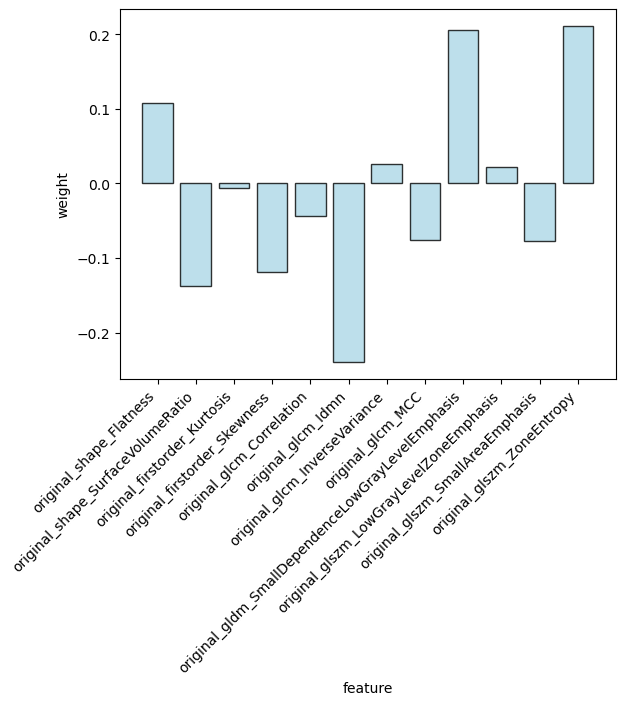

In [19]:
import matplotlib.pyplot as plt

x_values = np.arange(len(index))
y_values = coef[coef != 0]
plt.bar(x_values,y_values          #bar plot
        ,color = 'lightblue'  
        ,edgecolor = 'black'  
        ,alpha = 0.8  #不透明度
       )
plt.xticks(x_values,index
           ,rotation = '45'
           ,ha = 'right'
           ,va = 'top'
          )
plt.xlabel('feature')
plt.ylabel('weight')
plt.show()

## 八、ROC曲线及AUG值

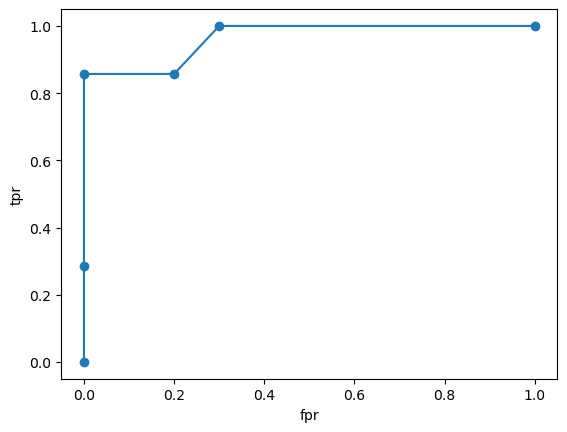

0.8571428571428572


In [20]:
from sklearn.metrics import roc_curve, roc_auc_score

y_probs = model_svm.predict_proba(X)
#print(y_probs)
#print(y_probs[:,1])
fpr,tpr,thresholds = roc_curve(y,y_probs[:,1],pos_label = 1)

plt.plot(fpr,tpr,marker = 'o')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()

auc_score = roc_auc_score(y,model_svm.predict(X))
print(auc_score)

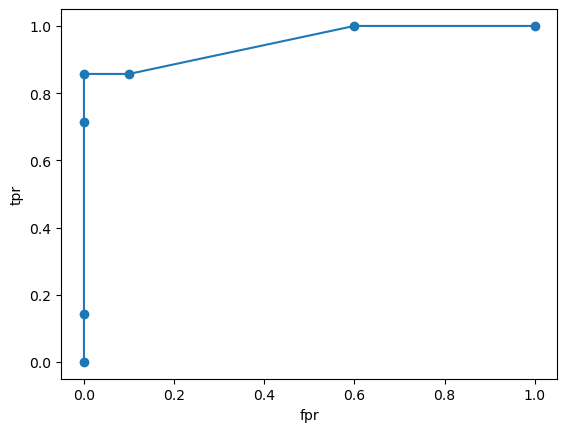

0.8571428571428572


In [21]:
from sklearn.metrics import roc_curve, roc_auc_score

y_probs = model_rf.predict_proba(X)
#print(y_probs)
#print(y_probs[:,1])
fpr,tpr,thresholds = roc_curve(y,y_probs[:,1],pos_label = 1)

plt.plot(fpr,tpr,marker = 'o')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()

auc_score = roc_auc_score(y,model_svm.predict(X))
print(auc_score)

## 九、Lasso作图
### 图1

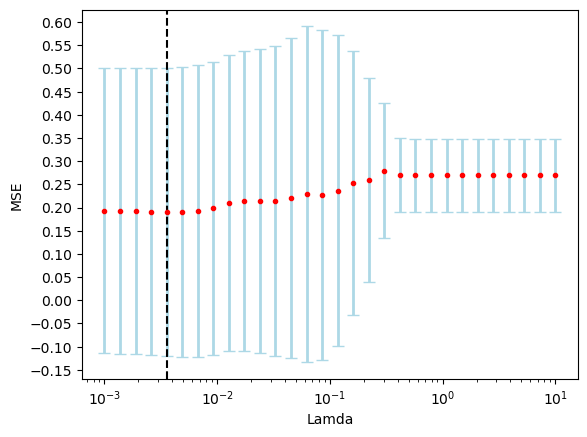

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

MSEs = model_lassoCV.mse_path_
'''
MSEs_mean, MSE_std = [],[]
for i in range(len(MESs)):
    MSEs_mean.append(MSEs[i].mean())
    MSEs_std.append(MSEs[i].std())
'''

MSEs_mean = np.apply_along_axis(np.mean,1,MSEs)
MSEs_std = np.apply_along_axis(np.std,1,MSEs)

plt.figure() # dpi = 300
plt.errorbar(model_lassoCV.alphas_,MSEs_mean
            ,yerr = MSEs_std
            ,fmt = 'o' 
            ,ms = 3 # dot size
            ,mfc = 'r' # dot color
            ,mec = 'r' # dot margin color
            ,ecolor = 'lightblue' 
            ,elinewidth = 2 # error bar width
            ,capsize = 4  # cap length of error bar 
            ,capthick = 1) 
plt.semilogx()
plt.axvline(model_lassoCV.alpha_,color = 'black',ls = '--')
plt.xlabel('Lamda')
plt.ylabel('MSE')
ax = plt.gca()
y_major_locator = ticker.MultipleLocator(0.05)
ax.yaxis.set_major_locator(y_major_locator)
plt.show()

#### 图2

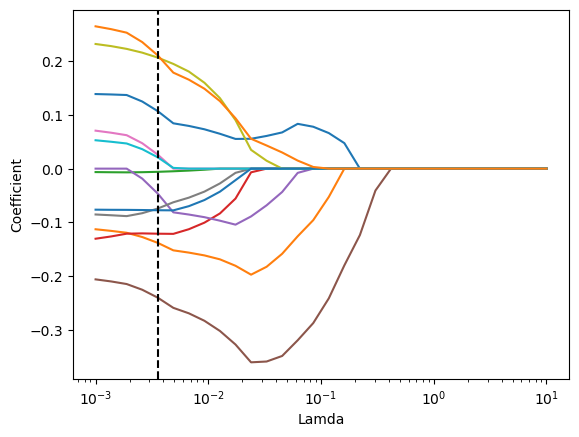

In [23]:
coefs = model_lassoCV.path(X,y,alphas = alphas, cv = 10, max_iter = 100000)[1].T
plt.figure()
plt.semilogx(model_lassoCV.alphas_,coefs,'-')
plt.axvline(model_lassoCV.alpha_,color = 'black',ls = '--')
plt.xlabel('Lamda')
plt.ylabel('Coefficient')
plt.show()

## 十、数据标准化和归一化
 为什么要进行标准化 /归一化：机器学习算法的要求；便于横向比较
 标准化————异常值一般对结果影响不大

使用时机
 1.特征提取后，特征筛选之前
 2.最初的影像处理

In [24]:
from sklearn.preprocessing import StandardScaler
data_sta = [[10,-20],[0.3,999],[-1,12],[0.3,21]]
res =StandardScaler().fit_transform(data_sta)

归一化————异常值可能对结果有重要影响

from sklearn.preprocessing import MinMaxScaler
data_sta = [[10,-20],[0.3,999],[-1,12],[0.3,21]]
res = MinMaxScaler().fit_transform(data_sta)


或者

In [25]:
from sklearn.preprocessing import RobustScaler
data_sta = [[10,-20],[0.3,999],[-1,12],[0.3,21]]
res = RobustScaler().fit_transform(data_sta)